# Model

In [1]:
!pip install imblearn

In [2]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import ipyleaflet
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns

# Data Science
import numpy as np
import numpy.ma as ma
import pandas as pd
import xarray as xr

# Feature Engineering
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, Normalizer
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score,classification_report,confusion_matrix
from sklearn.ensemble import IsolationForest, GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, roc_auc_score, f1_score, precision_recall_fscore_support
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif
from sklearn.model_selection import KFold
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.feature_selection import RFECV
import imblearn
# Planetary Computer Tools
import pystac
import pystac_client
import odc
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
from odc.stac import stac_load
import planetary_computer as pc
#pc.settings.set_subscription_key('******')

# Others
import requests
import rich.table
from itertools import cycle
from tqdm import tqdm
tqdm.pandas()
import os

In [3]:
os.chdir('/home/jovyan/EY-Crop-identification')
print(os.getcwd())

/home/jovyan/EY-Crop-identification


In [4]:
crop_data = pd.read_parquet("Data/crop_data_features_train.parquet.gzip")
crop_data = crop_data.drop(["Latitude and Longitude", "Latitude", "Longitude"], axis=1)
# Remove columns starting with 'ndvi_clean' as 'ndvi_clean' contains too many NANs
crop_data = crop_data.drop(columns=[col for col in crop_data.columns if col.startswith('ndvi_clean')])

In [5]:
crop_data.isna().sum().sum()

0

# Preprocessing

In [6]:
def AD_IForest(df, anomaly_ratio=0.015, n_trees=100):
    """
    Use Isolation Forest to detect potential outliers,
    takes df as input, return indexes of anomalies,
    score < 0 --> outliers
    """
    model_IF = IsolationForest(contamination=anomaly_ratio, n_estimators=n_trees, random_state=42)
    model_IF.fit(df)
    inliers = model_IF.predict(df)
    inlier_idx = np.where(inliers == 1)[0]
    outlier_idx = np.where(inliers == -1)[0]
    return inlier_idx, outlier_idx


def preproc_data(X, y, anomaly_ratio=0.01):
    '''
    preprocess data 
    fill NAN with mean
    Anomaly detection
    Oversample
    '''
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    X = imputer.fit_transform(X)
    ## Anomaly detection
    inlier_idx, outlier_idx = AD_IForest(X, anomaly_ratio=0.005, n_trees=100)
    print(f"Drop {len(X) - len(inlier_idx)} outliers")
    X = np.array(X[inlier_idx])
    y = np.array(y[inlier_idx])
    # Oversample
    oversample = imblearn.over_sampling.SMOTE(random_state=100, k_neighbors=5)
    X, y = oversample.fit_resample(X, y)
    print(X.shape)
    return X, y

In [7]:
def cv_train(kfold, scalers, models, X, y):
    '''
    A pipeline contains a scaler and a model.
    To select the best combinations, we train each pipeline in a k-fold CV,
    taking the average f1-score across all folds as the
    pipeline score.
    
    return the scores and best combination
    '''
    scores = {}
    max_score = 0
    best_comb = ()
    for scaler_name in scalers:
        scaler_score = 0
        scores[scaler_name] = {}
        print(f'Training models using: {scaler_name} scaler')
        for model_name in models:
            print(f'  Training {model_name} model')
            scaler = scalers[scaler_name]
            model = models[model_name]
            pipe = Pipeline([
                ('scaler', scaler),
                ('model', model),
            ])
            if scaler_name == "None":
                # without scaler
                pipe = Pipeline([
                ('model', model)
            ])
            score = 0
            # train models with kfold and compute the avg f1 score across all folds
            for train_index, val_index in kfold.split(X):
                X_train, X_val = X[train_index], X[val_index]
                y_train, y_val = y[train_index], y[val_index]
                pipe.fit(X_train, y_train)
                y_pred = pipe.predict(X_val)
                score += f1_score(y_true=y_val, y_pred=y_pred, pos_label="Rice")
            fold_score = score/kfold.get_n_splits()
            scores[scaler_name][model_name] = fold_score
            scaler_score += fold_score
            if fold_score > max_score:
                best_comb = (scaler_name, model_name)
            max_score = max(max_score, fold_score)
        print("scalar score avg: ", scaler_score / len(models))
    return scores, best_comb

def k_fold_val(model, param_grid, X_train, y_train, num_fold=5, scoring="f1"):
    '''
    Use GridSearch and k-fold CV to find the best hyperparameters for the model.
    '''
    # Use stratifiedKfold to ensure equal distribution of classes.
    kfolds = StratifiedKFold(num_fold)
    grid = GridSearchCV(model, param_grid, n_jobs=1,
                        cv=kfolds.split(X_train,
                                        y_train), scoring=scoring, verbose=1)
    grid.fit(X_train, y_train)
    return grid

## plot confusion matrix

In [8]:
def plot_confusion_matrix(true_value,predicted_value,title,labels):
    '''
    Plots a confusion matrix.
    Attributes:
    true_value - The ground truth value for comparision.
    predicted_value - The values predicted by the model.
    title - Title of the plot.
    labels - The x and y labels of the plot.
    '''
    cm = confusion_matrix(true_value,predicted_value)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues');
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels');
    ax.set_title(title);
    ax.xaxis.set_ticklabels(labels);
    ax.yaxis.set_ticklabels(labels);

## train test split

In [9]:
X = crop_data.drop(columns=['Class of Land']).values
y = crop_data ['Class of Land'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=40)

In [10]:
X_train, y_train = preproc_data(X_train, y_train)

Drop 3 outliers
(480, 186)


In [11]:
X_train.shape

(480, 186)

## Model Training

### Model selection

In [12]:
models = {
    'gb': GradientBoostingClassifier(criterion="squared_error", n_estimators=20, max_depth=None, random_state=7),
    'rf': RandomForestClassifier(n_estimators=20, n_jobs=-1, random_state=7),
    'svc':SVC(max_iter=500),
    'MLPC': MLPClassifier(),
    "knn": KNeighborsClassifier(n_neighbors=10),
    "decisiontree": DecisionTreeClassifier()
    
}
scalers = {
    "minmax": MinMaxScaler(),
    "standard": StandardScaler(),
    "robust": RobustScaler(),
    "maxabs": MaxAbsScaler(),
    "normalizer": Normalizer(),
    "None": None

}
kfold = KFold(n_splits=5)
model_scores, best_comb = cv_train(kfold, scalers, models, X_train, y_train)

Training models using: minmax scaler
  Training gb model
  Training rf model
  Training svc model
  Training MLPC model
  Training knn model
  Training decisiontree model
scalar score avg:  0.9978938222062163
Training models using: standard scaler
  Training gb model
  Training rf model
  Training svc model
  Training MLPC model
  Training knn model
  Training decisiontree model
scalar score avg:  0.9968542014404096
Training models using: robust scaler
  Training gb model
  Training rf model
  Training svc model
  Training MLPC model
  Training knn model
  Training decisiontree model
scalar score avg:  0.8632767818721248
Training models using: maxabs scaler
  Training gb model
  Training rf model
  Training svc model
  Training MLPC model
  Training knn model
  Training decisiontree model
scalar score avg:  0.9975644272903551
Training models using: normalizer scaler
  Training gb model
  Training rf model
  Training svc model
  Training MLPC model
  Training knn model
  Training decisi

In [13]:
model_scores

{'minmax': {'gb': 1.0,
  'rf': 1.0,
  'svc': 0.9978494623655914,
  'MLPC': 0.9958745348219032,
  'knn': 0.9978947368421054,
  'decisiontree': 0.9957441992076967},
 'standard': {'gb': 1.0,
  'rf': 1.0,
  'svc': 0.9916112561273852,
  'MLPC': 0.9937244788308618,
  'knn': 0.9978947368421054,
  'decisiontree': 0.9978947368421054},
 'robust': {'gb': 1.0,
  'rf': 1.0,
  'svc': 0.2610459962572639,
  'MLPC': 0.9817776704644359,
  'knn': 0.938987562145457,
  'decisiontree': 0.9978494623655914},
 'maxabs': {'gb': 1.0,
  'rf': 1.0,
  'svc': 0.9978494623655914,
  'MLPC': 0.9958745348219032,
  'knn': 0.9978947368421054,
  'decisiontree': 0.9937678297125302},
 'normalizer': {'gb': 0.9320819214051698,
  'rf': 0.9813883741861439,
  'svc': 0.5884207473829509,
  'MLPC': 0.6572540800904427,
  'knn': 0.5225614117499859,
  'decisiontree': 0.9324946813147619},
 'None': {'gb': 1.0,
  'rf': 1.0,
  'svc': 0.2610459962572639,
  'MLPC': 0.5799627317684635,
  'knn': 0.4457217492916447,
  'decisiontree': 1.0}}

As the result, RF achieves the most number of perfect scores, and MinMaxScaler has the highest avg f1 across all models.

### Hyperparameter tuning
Tune the random forest classifier using grid search and perform feature selection using ANOVA F-value

In [14]:
param_grid = {'feature__score_func': [f_classif],
              # tune the number of features to select
              'feature__k': [100, 120, 150], 
              'model__n_estimators': [20, 30, 40, 50],
              'model__max_depth': [None, 10, 20, 30],
              'model__min_samples_split': [2, 5],
              'model__min_samples_leaf': [1, 2],
              'model__max_features': ['sqrt', 'log2'],
              'model__bootstrap': [True, False],
              'model__n_jobs': [-1],
              'model__random_state': [7]
              }


pipe = Pipeline([
        ('scaler', MinMaxScaler()),
        # add feature selection
        ('feature', SelectKBest()),
        ('model', RandomForestClassifier()),
        ])
k_fold = k_fold_val(pipe, param_grid, X_train, y_train, num_fold=5)

Fitting 5 folds for each of 768 candidates, totalling 3840 fits


In [15]:
k_fold.best_params_

{'feature__k': 100,
 'feature__score_func': <function sklearn.feature_selection._univariate_selection.f_classif(X, y)>,
 'model__bootstrap': True,
 'model__max_depth': None,
 'model__max_features': 'sqrt',
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 20,
 'model__n_jobs': -1,
 'model__random_state': 7}

In [16]:
model = k_fold.best_estimator_

In [17]:
model.named_steps

{'scaler': MinMaxScaler(),
 'feature': SelectKBest(k=100),
 'model': RandomForestClassifier(n_estimators=20, n_jobs=-1, random_state=7)}

## Model Training

In [18]:

def train(X, y, model):
    X, y = preproc_data(X, y)
    model.fit(X, y)
    insample_predictions = model.predict(X)
    print("Insample Accuracy {0:.2f}%".format(100 * accuracy_score(insample_predictions, y)))
    print(classification_report(insample_predictions, y))
    plot_confusion_matrix(y, insample_predictions, "Model Level 1: RF Model In-Sample Results",
                          ['Rice', 'Non Rice'])
    return model

## Model Evaluation

In [19]:
def test(X, y, model):
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    X = imputer.fit_transform(X)
    outsample_predictions = model.predict(X)
    print("Accuracy {0:.2f}%".format(100*accuracy_score(outsample_predictions, y)))
    print(classification_report(y, outsample_predictions))
    plot_confusion_matrix(y, outsample_predictions,"Model Level 1: RF Model Out-Sample Results",['Rice', 'Non Rice'])

## Train model

Train the tuned model

Drop 3 outliers
(480, 186)
Insample Accuracy 100.00%
              precision    recall  f1-score   support

    Non Rice       1.00      1.00      1.00       240
        Rice       1.00      1.00      1.00       240

    accuracy                           1.00       480
   macro avg       1.00      1.00      1.00       480
weighted avg       1.00      1.00      1.00       480



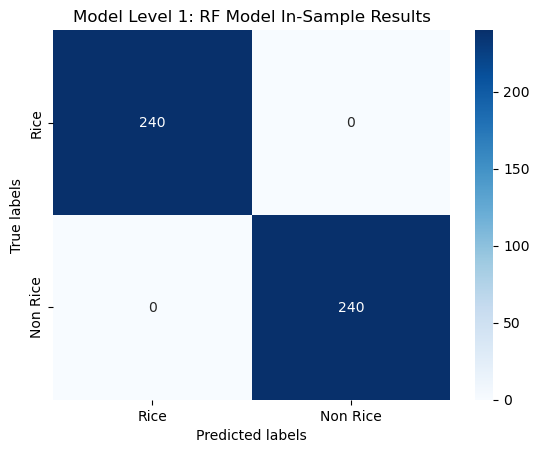

In [20]:
model = train(X_train, y_train, model)

## Out-sample evaluation

Accuracy 100.00%
              precision    recall  f1-score   support

    Non Rice       1.00      1.00      1.00        60
        Rice       1.00      1.00      1.00        60

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120



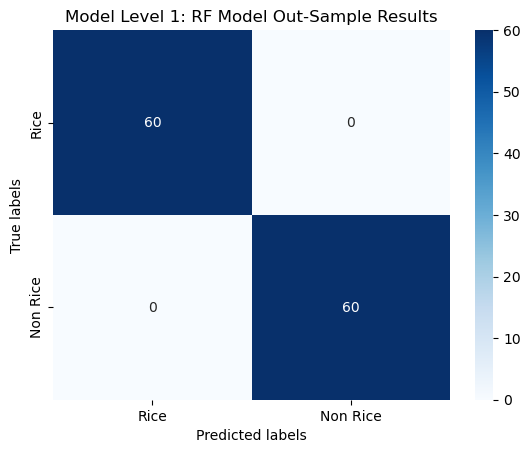

In [21]:
test(X_test, y_test, model)

## Train model using all data

Drop 3 outliers
(600, 186)
Insample Accuracy 100.00%
              precision    recall  f1-score   support

    Non Rice       1.00      1.00      1.00       300
        Rice       1.00      1.00      1.00       300

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



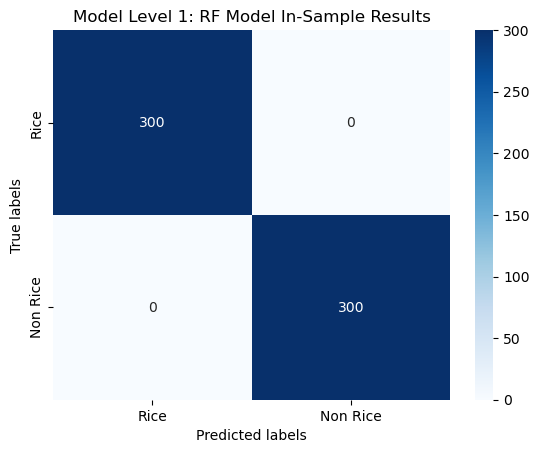

In [22]:
model = train(X, y, model)

## Make submission

In [23]:
crop_data_test = pd.read_parquet("Data/crop_data_features_test.parquet.gzip")

In [24]:
# Feature Scaling
submission_vh_vv_data = crop_data_test.drop(["Latitude and Longitude", "target", "Latitude", "Longitude"], axis=1)
# Remove columns starting with 'ndvi_clean'
submission_vh_vv_data = submission_vh_vv_data.drop(columns=[col for col in crop_data_test.columns if col.startswith('ndvi_clean')])

In [25]:
# fill missing values with mean
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
submission_vh_vv_data = imputer.fit_transform(submission_vh_vv_data)

In [26]:
#Making predictions
final_predictions = model.predict(submission_vh_vv_data)
final_prediction_series = pd.Series(final_predictions)

In [27]:
#Combining the results into dataframe
submission_df = pd.DataFrame({'id':crop_data_test['Latitude and Longitude'].values, 'target':final_prediction_series.values})

In [28]:
#Displaying the sample submission dataframe
display(submission_df)

,id,target
0,"(10.18019073690894, 105.32022315786804)",Rice
1,"(10.561107033461816, 105.12772097986661)",Rice
2,"(10.623790611954897, 105.13771401411867)",Rice
3,"(10.583364246115156, 105.23946127195805)",Non Rice
4,"(10.20744446668854, 105.26844107128906)",Rice
...,...,...
245,"(10.308283266873062, 105.50872812216863)",Non Rice
246,"(10.582910017285496, 105.23991550078767)",Non Rice
247,"(10.581547330796518, 105.23991550078767)",Non Rice
248,"(10.629241357910818, 105.15315779432643)",Rice


In [29]:
#Dumping the predictions into a csv file.
submission_df.to_csv("Output/challenge_1_submission_rice_crop_prediction.csv",index = False)

In [30]:
import pickle

# Save the trained model to a file
filename = 'Models/final_model_rf.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model, file)
